In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.rc = {'figure.figsize': (10,6)}
%matplotlib inline

## Select a region of interest using FFTs

This example shows how to crop an image using Nanomesh using the characteristics of an FFT to select a bbox matching the lattice of the crystal.

This example shows how to crop an image using sample data from `nanomesh.data`.

If you want to use your own data, any numpy array can be passed to into an `Image` object. This will create a [`Volume`](https://nanomesh.readthedocs.io/en/latest/nanomesh.volume.html#nanomesh.volume.Volume) or [`Plane`](https://nanomesh.readthedocs.io/en/latest/nanomesh.plane.html#nanomesh.plane.Plane) object depending on the data dimensions. Data stored as `.npy` can be loaded using `Image.load()`.

In [2]:
from nanomesh import Image
from nanomesh.data import nanopores3d

data = nanopores3d()

vol = Image(data)
plane = vol.select_plane(x=161)

This operation takes the fft of the image, and creates a regular array of the recurring components. The distance between the peaks in the image correspond to the distance between the pores in the source image.

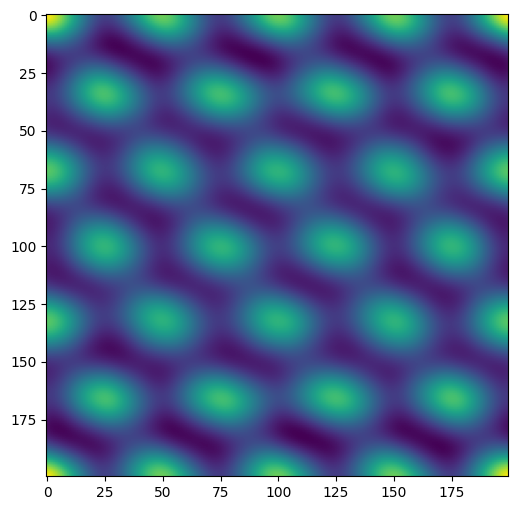

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def abs2(x):
    return x.real**2 + x.imag**2


fft = np.fft.fft2(plane.image)
ifft = np.fft.ifft2(abs2(fft))

filtered = abs(ifft)

plt.figure()
plt.imshow(filtered)
plt.show()

### Peak-finding

Use a Difference of Gaussian to find the peaks in the image.

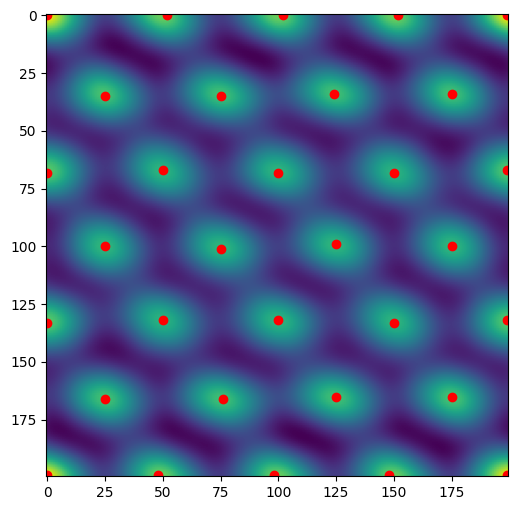

In [4]:
from skimage import feature

peaks = feature.blob_dog(filtered,
                         min_sigma=10,
                         max_sigma=20,
                         overlap=1,
                         threshold=5)
peaks = peaks[:, 0:2]
x, y = peaks.T

plt.figure()
plt.imshow(filtered)
plt.scatter(y, x, color='red')
plt.show()

### ROI picking

A Delauney triangulation is used to create a mesh out of the peaks. The mesh is subdivided once to create additional granularity for the point picking in the roi selection.

In [5]:
from scipy.spatial import Delaunay
from nanomesh import TriangleMesh

tris = Delaunay(peaks)
triangles = TriangleMesh.from_scipy(tris)

The subdivision uses [trimesh](https://trimsh.org/trimesh.remesh.html#trimesh.remesh.subdivide).

In [6]:
trimesh = triangles.to_trimesh()
trimesh_subdivided = trimesh.subdivide()
triangles = TriangleMesh.from_trimesh(trimesh_subdivided)

The vertices are passed to the `.select_roi` method to pick from.

- By passing `from_points`, vertices snap to the nearest point (use 'ctrl' to drag it away)
- Press the 'esc' key to start a new polygon
- Hold the 'shift' key to move all of the vertices
- Hold the 'ctrl' key to move a single vertex

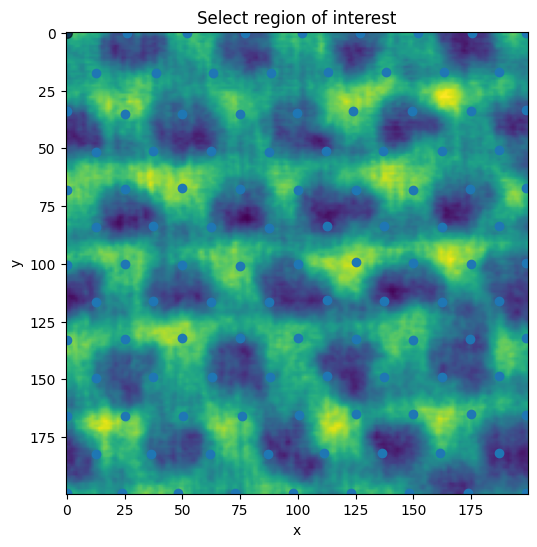

In [7]:
roi = plane.select_roi(from_points=triangles.points)

The `.bbox` attribute is updated when the selection above changes.

In [8]:
roi.bbox

array([[0, 0],
       [0, 1],
       [1, 1],
       [1, 0]])

Use the `.crop_to_roi` method to extract the region of interest.

<AxesSubplot:xlabel='x', ylabel='y'>

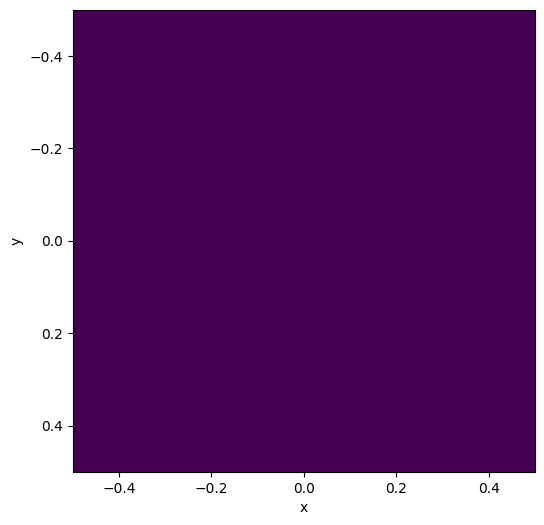

In [9]:
plane_roi = plane.crop_to_roi(bbox=roi.bbox)
plane_roi.show()